# builelibの出力JSONからグラフを作成

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

## 計算結果を読み込む

In [2]:
js = open('builelib_data/builelib_result_AC.json', mode='r', encoding='utf-8')

In [3]:
dict = json.load(js)

In [4]:
# 室負荷の読み込み
room_load_c = np.array(dict['Qroom']['２F_事務室']['QroomDc'])
room_load_h = np.array(dict['Qroom']['２F_事務室']['QroomDh'])

# 外気負荷の読み込み
vent_load = np.array(dict['AHU']['EHP1-1']['qoaAHU'])

In [5]:
# pandaにデータを読み込ませる
date_index_daily = pd.date_range(datetime(1989, 1, 1), datetime(1989, 12, 31), freq='D')
dd = pd.DataFrame(index=date_index_daily)
dd['room_load_c'] = room_load_c
dd['room_load_h'] = room_load_h
dd['vent_load'] = vent_load

In [6]:
# 月集計[GJ]
date_index_monthly = pd.date_range(datetime(1989, 1, 1), datetime(1989, 12, 31), freq='M')
dm = pd.DataFrame(index=date_index_monthly)
dm['room_load_c'] = dd['room_load_c'].resample('M').sum()
dm['room_load_h'] = dd['room_load_h'].resample('M').sum()
dm['vent_load_c'] = (dd[dd['vent_load'] > 0.0])['vent_load'].resample('M').sum()
dm['vent_load_h'] = (dd[dd['vent_load'] < 0.0])['vent_load'].resample('M').sum()

## 日積算室負荷のグラフ作成

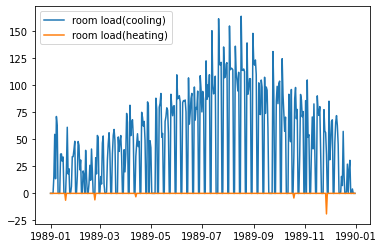

In [7]:
fig = plt.figure()
ax = fig.subplots()

ax.plot(dd['room_load_c'], label='room load(cooling)')
ax.plot(dd['room_load_h'], label='room load(heating)')

plt.legend()
plt.show()

## 日積算外気負荷のグラフ

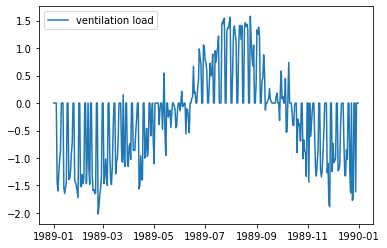

In [8]:
fig = plt.figure()
ax = fig.subplots()

ax.plot(dd['vent_load'], label='ventilation load')

plt.legend()
plt.show()

## 月積算室負荷のグラフ

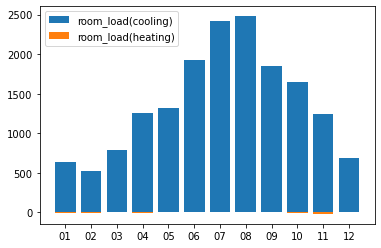

In [22]:
plt.bar(dm.index.strftime('%m'), dm['room_load_c'], label='room_load(cooling)')
plt.bar(dm.index.strftime('%m'), dm['room_load_h'], label='room_load(heating)')

plt.legend()
plt.show()

## 月積算外気負荷のグラフ

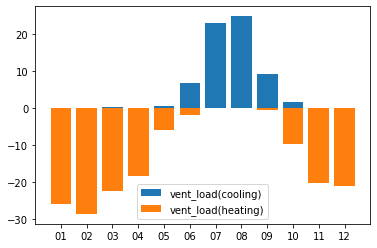

In [23]:
plt.bar(dm.index.strftime('%m'), dm['vent_load_c'], label='vent_load(cooling)')
plt.bar(dm.index.strftime('%m'), dm['vent_load_h'], label='vent_load(heating)')

plt.legend()
plt.show()